In [ ]:
!jupyter nbconvert --to script pipeline_1.ipynb

In [1]:
import os
import matplotlib.pylab as plt
from glob import glob
import numpy as np
import PIL.Image as PIL

# READ IMAGES AND MASKS

In [2]:
PATH = os.path.abspath('data')

SOURCE_IMAGES = os.path.join(PATH, "images/ds*")

images = glob(os.path.join(SOURCE_IMAGES, "*.jpg"))

SOURCE_LABELS = os.path.join(PATH, "labels/ds*")

labels = glob(os.path.join(SOURCE_LABELS, "*.png"))

In [3]:
images.sort()
labels.sort()

In [4]:
print(np.size(images))
print(np.size(labels))

143
143


In [5]:
x = [] # images
y = [] # labels

for img in images:
    full_size_image = plt.imread(img)
    x.append(full_size_image)

for lbl in labels:
    full_size_label = plt.imread(lbl,0)
    y.append(full_size_label)

In [6]:
x = np.asarray(x)
y = np.asarray(y)

In [7]:
print(y.min())
print(y.max())
print(x.shape)
print(y.shape)

0
8
(143, 1024, 1280, 3)
(143, 1024, 1280)


In [8]:
# Crop squared image
n_images, h, w = x.shape[0:3]

x = x[:,:,(w-h)//2:(w-(w-h)//2),:]
y = y[:,:,(w-h)//2:(w-(w-h)//2)]

n_images, h, w = x.shape[0:3]

print(x.shape)
print(y.shape)

(143, 1024, 1024, 3)
(143, 1024, 1024)


# Split images and masks into batches (optional)

In [9]:
h_t, w_t = (512,512)
split_factor = 4 # We crop this number of smaller images out of one
x_t = np.zeros([n_images*split_factor, h_t, w_t, 3], dtype='uint8')
y_t = np.zeros([n_images*split_factor, h_t, w_t], dtype='uint8')

In [10]:
print(x_t.shape)
print(y_t.shape)

(572, 512, 512, 3)
(572, 512, 512)


In [11]:
for i in range(n_images):
    x_t[i] = x[i,:h//2,:w//2,:]
    x_t[n_images+i] = x[i,:h//2,w//2:w,:]
    x_t[n_images*2+i] = x[i,h//2:h,:w//2,:]
    x_t[n_images*3+i] = x[i,h//2:h,w//2:w,:]
    y_t[i] = y[i,:h//2,:w//2]
    y_t[n_images+i] = y[i,:h//2,w//2:w]
    y_t[n_images*2+i] = y[i,h//2:h,:w//2]
    y_t[n_images*3+i] = y[i,h//2:h,w//2:w]

In [12]:
print(x.shape)
print(y.shape)

(143, 1024, 1024, 3)
(143, 1024, 1024)


In [13]:
print(x_t.shape)
print(y_t.shape)

(572, 512, 512, 3)
(572, 512, 512)


In [14]:
x = x_t
y = y_t
del(x_t,y_t)

# Class weighting

In [15]:
n = np.bincount(y.reshape(y.shape[0]*y.shape[1]*y.shape[2]))

In [16]:
print(str(n/n.sum()*100) + " %")

[  1.79078362   5.26118645   6.04894878   8.94054133  42.71272313
  16.75772033   8.06135631   9.98005233   0.44668771] %


In [17]:
cs = ['background','asphalt', 'building', 'forest', 'grass', 'ground', 'roadAsphalt', 'roadGround', 'water']

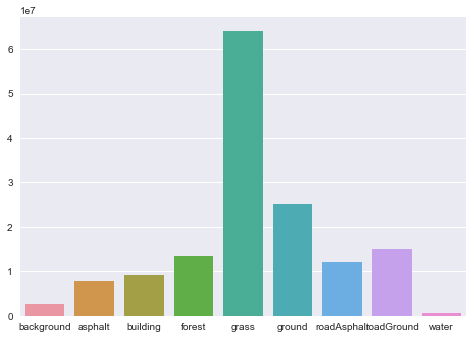

In [18]:
import seaborn as sns

sns.barplot(x=cs, y=n)

In [19]:
cw = np.median(n)/n

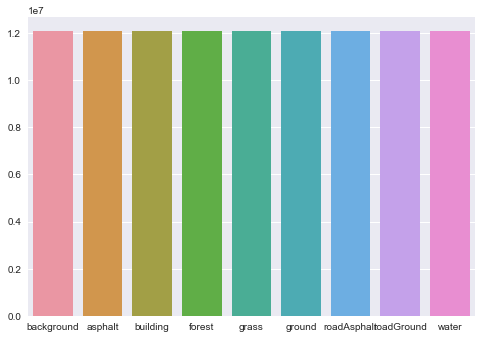

In [20]:
sns.barplot(x=cs, y=n*cw)

In [21]:
class_weights = dict(enumerate(cw))
class_weighting = np.fromiter(class_weights.values(), dtype=float)
class_weighting

array([  4.50158032,   1.53223163,   1.33268715,   0.90166311,
         0.18873431,   0.48105328,   1.        ,   0.8077469 ,  18.04696234])

# Convert one mask to N classes masks

In [22]:
#Convert batch of masks from 1 to N of classes
def one_to_n(y,n):
    n_images, h, w = y.shape
    y = y.reshape([n_images, h*w])
    temp = np.zeros(np.append(y.shape,n_classes),dtype='int')
    for i in range (n_images):
        for j in range(h*w):
            temp[i,j,(y[i,j])] = 1
    return temp.reshape([n_images,h,w,n])

def n_to_one(y):
    n_images, h, w, n = y.shape
    y = y.reshape([n_images, h*w, n])
    temp = np.zeros([n_images, h*w],dtype='int')
    for i in range (n_images):
        for j in range(h*w):
            temp[i,j] = np.argmax(y[i,j])
    return temp.reshape([n_images,h,w])

In [23]:
n_classes = len(cs)
y = one_to_n(y,n_classes)
# y = n_to_one(y)
y.shape

(572, 512, 512, 9)

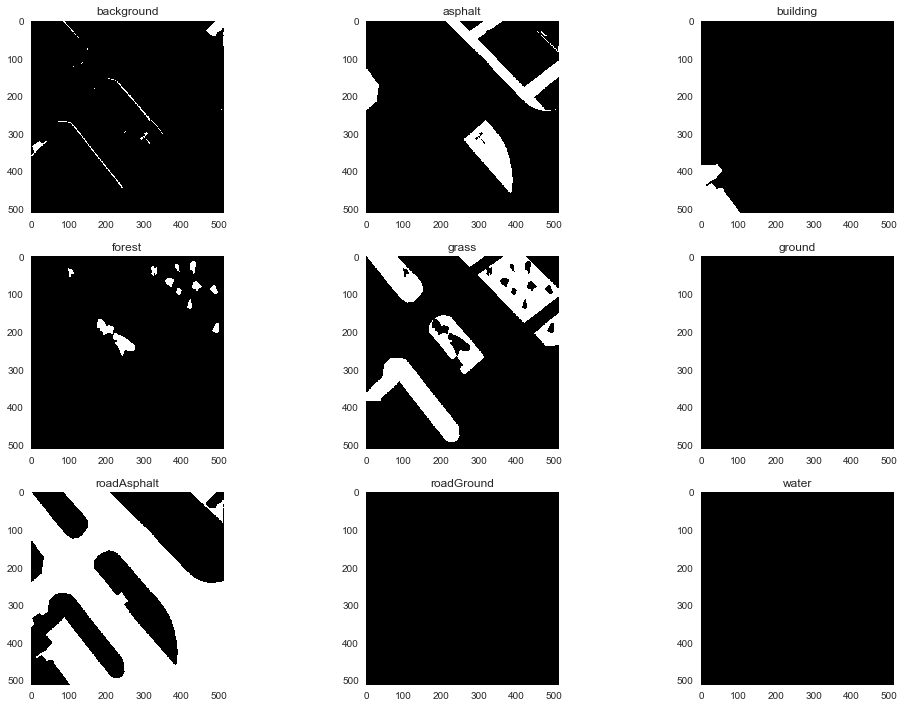

In [24]:
nrows, ncols = 3,3
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(15,10)
cl = 0
im = 59
for i in range(nrows):
    for j in range(ncols):
        axes[i,j].imshow(y[im,:,:,cl], cmap='gray')
        axes[i,j].set_title(cs[cl])
        axes[i,j].grid(None)
        cl += 1
     
fig.tight_layout()

In [25]:
# x = x/255

In [26]:
y = y.reshape([y.shape[0], y.shape[1]*y.shape[2],y.shape[3]])
y.shape

(572, 262144, 9)

# Prepare for training

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

In [ ]:
K.image_data_format()

In [ ]:
img_height, img_width = x_train.shape[1:3]
nb_train_samples = len(x_train)
nb_test_samples = len(x_test)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, rotation_range=30)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
epochs = 1
batch_size = 1

In [ ]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

# Define model

# U-Net

In [ ]:
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(pretrained_weights = None, input_size = (256,320,3), n_classes = 9):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(n_classes, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Reshape((input_size[0]*input_size[1],n_classes))(conv10)
    conv10 = Activation('softmax')(conv10)
    
    model = Model(inputs = inputs, outputs = conv10)
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:
model = unet(input_size = (img_height,img_width,3), n_classes=9)
model.compile(optimizer = 'adadelta', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.001)

In [ ]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_test_samples // batch_size,
    verbose = 1,
    class_weight = class_weighting
)

In [ ]:
y_train_flat = y_train.reshape(y_train.shape[0],y_train.shape[1]*y_train.shape[2],y_train.shape[3])
y_train_flat.shape

In [ ]:
y_test_flat = y_test.reshape(y_test.shape[0],y_test.shape[1]*y_test.shape[2],y_test.shape[3])
y_test_flat.shape

In [ ]:
def get_tf_session():
    gpu_options = tf.GPUOptions(allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(get_tf_session())

In [ ]:
history = model.fit(x_train, y_train_flat, batch_size=1, epochs=10, verbose=1, class_weight=class_weighting)

In [ ]:
model.save_weights('weights/model_weight_ep10.hdf5')

In [ ]:
score = model.evaluate(x_test, y_test_flat, batch_size = 1, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### Test pretrained model

In [ ]:
model = unet(input_size = (img_height,img_width,3), n_classes=9)

In [ ]:
model.load_weights('weights/model_weight_ep10.hdf5')

In [ ]:
score = model.evaluate(x_test, y_test_flat, batch_size = 1, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
model.metrics_names

In [ ]:
y_test_pred = model.predict(x_test, batch_size = 1, verbose = 1)

In [ ]:
y_test_pred.shape

In [ ]:
np.argmax(y_test_pred[0,55555])

In [ ]:
y_test_pred[0,0]

In [ ]:
y_test_flat.dtype

In [ ]:
temp = np.zeros((y_test_flat.shape[0], y_test_flat.shape[1]), dtype='int')

In [ ]:
for i in range (y_test_flat.shape[0]):
    for j in range(y_test_flat.shape[1]):
            temp[i,j] = np.argmax(y_test_flat[i,j])
    print(i)

In [ ]:
temp_pred = np.zeros((y_test_pred.shape[0], y_test_pred.shape[1]), dtype='int')
for i in range (y_test_pred.shape[0]):
    for j in range(y_test_pred.shape[1]):
            temp_pred[i,j] = np.argmax(y_test_pred[i,j])
    print(i)

In [ ]:
y_test_flat.shape

In [ ]:
y_test_pred.shape

In [ ]:
hex_colors = ['#000000','#4A4A4A','#FF0000', '#407700', '#00FF37', '#8B572A', '#0000FF', '#FF7600', '#50E3C2']

In [ ]:
import webcolors

rgb_colors = []

for hex_color in hex_colors:
    rgb_colors.append(webcolors.hex_to_rgb(hex_color))

In [ ]:
def colorize(mask, colors):
    colorMask = np.zeros([mask.shape[0], mask.shape[1], 3],dtype=np.uint8)
    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            colorMask[r,c,] = colors[mask[r,c]]

    return colorMask

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20,10)

img = 0

axes[0].imshow(x_test[img])
axes[1].imshow(colorize(temp[img].reshape((y_test[0].shape[0], y_test[0].shape[1])), colors = np.array(rgb_colors)))
axes[2].imshow(colorize(temp_pred[img].reshape((y_test[0].shape[0], y_test[0].shape[1])), colors = np.array(rgb_colors)))

fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20,10)

for i in range (20):

    axes[0].imshow(x_test[i])
    axes[1].imshow(colorize(temp[i].reshape((y_test[0].shape[0], y_test[0].shape[1])), colors = np.array(rgb_colors)))
    axes[2].imshow(colorize(temp_pred[i].reshape((y_test[0].shape[0], y_test[0].shape[1])), colors = np.array(rgb_colors)))
    fig.tight_layout()
    fig.savefig('img{}'.format(i))



In [ ]:
y_test_flat[0].reshape(y_test[0].shape).shape

In [ ]:
y_test_flat.shape

In [ ]:
y_test_flat[0].reshape(y_test[0].shape).shape

# Training

# Load/Save model

In [ ]:
from keras.models import load_model
import pickle

In [ ]:
model.save('model2.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
model = load_model('model1.h5')

In [ ]:
with open('history2', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
history.history

# Evaluate

In [ ]:
iz = model.evaluate_generator(test_generator, max_queue_size=10, workers=1, use_multiprocessing=False, steps=None)

In [ ]:
a = model.evaluate(x_test, y_test, batch_size = batch_size, verbose=1, sample_weight=None, steps=None)

In [ ]:
a

In [ ]:
print(y_test.shape)
print(a.shape)

In [ ]:
def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_

def mean_accuracy(eval_segm, gt_segm):
    '''
    (1/n_cl) sum_i(n_ii/t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    accuracy = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
 
        if (t_i != 0):
            accuracy[i] = n_ii / t_i

    mean_accuracy_ = np.mean(accuracy)
    return mean_accuracy_

def mean_IU(eval_segm, gt_segm):
    '''
    (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl   = union_classes(eval_segm, gt_segm)
    _, n_cl_gt = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)
 
    mean_IU_ = np.sum(IU) / n_cl_gt
    return mean_IU_

def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_

'''
Auxiliary functions used during evaluation.
'''
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

'''
Exceptions
'''
class EvalSegErr(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)

In [ ]:
kek = pixel_accuracy(y_test_pred[0,:,:,0], y_test[0,:,:,0])

In [ ]:
a[0,:,:,0].shape

In [ ]:
kek

In [ ]:
y_test[0,:,:,0]